In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('bandwidth.csv')
df.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


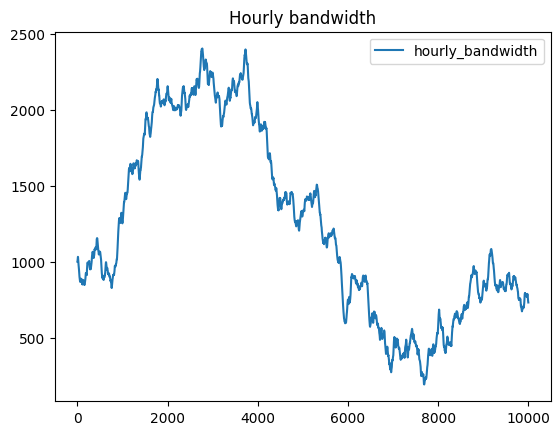

In [4]:
df.plot(title='Hourly bandwidth')
plt.show()

In [5]:
ADF_result = adfuller(df['hourly_bandwidth'])

print(f'ADF Statistics: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistics: -0.8714653199451994
p-value: 0.7972240255014788


In [8]:
# p-value > 0.05 > time series not stationary
bandwidth_diff = np.diff(df['hourly_bandwidth'], n=1)
bandwidth_diff

array([ 0.47269411,  1.07661104,  2.65609895, ..., -2.84823217,
       -2.49835551, -1.36959095])

In [10]:
ADF_result = adfuller(bandwidth_diff)
print(f'ADF Statistics: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistics: -20.694853863789028
p-value: 0.0


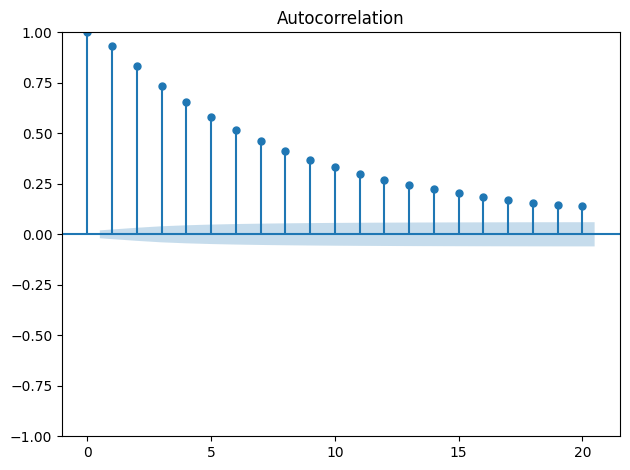

In [11]:
# Autocorrelation function - ACF plot

plot_acf(bandwidth_diff, lags=20)
plt.tight_layout()

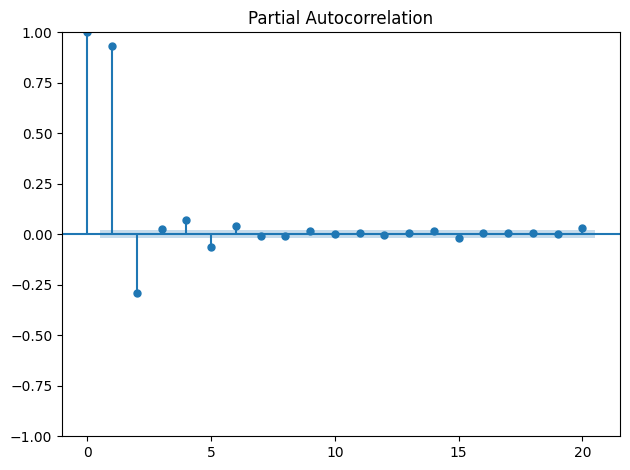

In [12]:
plot_pacf(bandwidth_diff, lags=20)
plt.tight_layout()

In [13]:
# Test Set: last 7 days of data

df_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})

train = df_diff[:-168]
test = df_diff[-168:]

print(len(train))
print(len(test))

9831
168


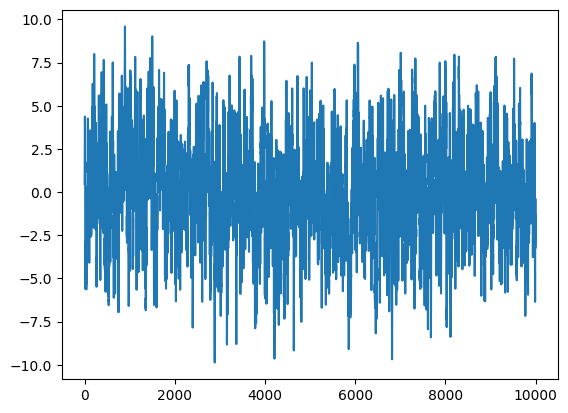

In [14]:
df_diff['bandwidth_diff'].plot()
plt.show()

In [17]:
def optimize_ARMA(data, order_list):
    results = []

    for order in order_list:
        try:
            model = SARIMAX(data, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index()
    return result_df

In [18]:
from itertools import product
ps = range(0, 4, 1)
print('ps', ps)
qs = range(0, 4, 1)
print('qs', qs)

order_list = list(product(ps, qs))
result_df = optimize_ARMA(train['bandwidth_diff'], order_list)
result_df

ps range(0, 4)
qs range(0, 4)


,index,"(p,q)",AIC
0,14,"(3, 2)",27991.063879
1,11,"(2, 3)",27991.287509
2,10,"(2, 2)",27991.603598
3,15,"(3, 3)",27993.416924
4,7,"(1, 3)",28003.349550
5,6,"(1, 2)",28051.351401
6,13,"(3, 1)",28071.155496
7,12,"(3, 0)",28095.618186
8,9,"(2, 1)",28097.250766
9,8,"(2, 0)",28098.407664


                               SARIMAX Results                                
Dep. Variable:         bandwidth_diff   No. Observations:                 9831
Model:               SARIMAX(3, 0, 2)   Log Likelihood              -13989.532
Date:                Tue, 14 Nov 2023   AIC                          27991.064
Time:                        22:45:49   BIC                          28034.224
Sample:                             0   HQIC                         28005.686
                               - 9831                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3532      0.053      6.668      0.000       0.249       0.457
ar.L2          0.4150      0.066      6.250      0.000       0.285       0.545
ar.L3          0.0546      0.036      1.530      0.1

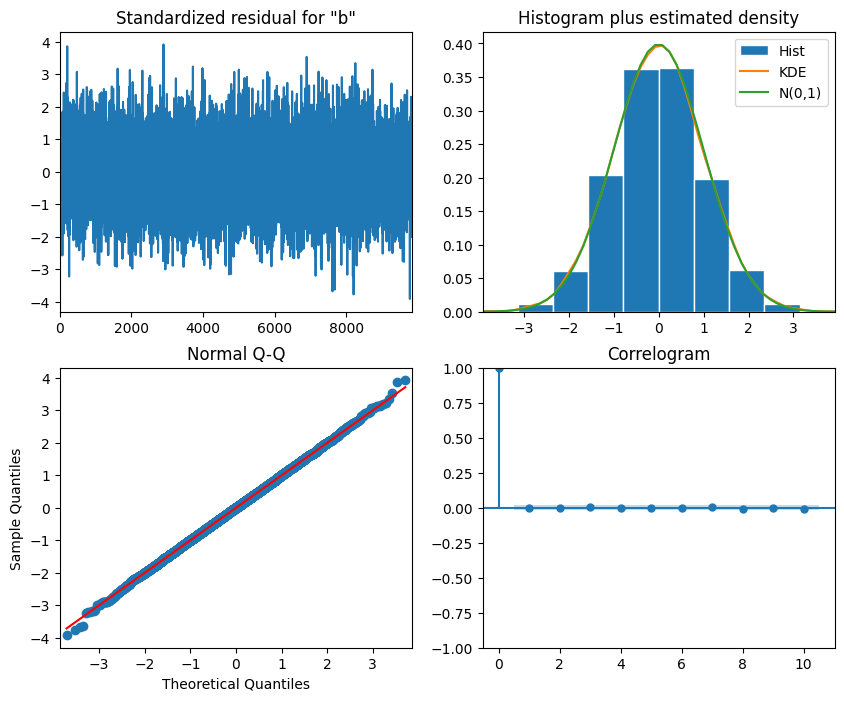

In [19]:
model = SARIMAX(train['bandwidth_diff'], order=(3,0,2), simple_differencing=False)

model_fit = model.fit(disp=False)
print(model_fit.summary())

model_fit.plot_diagnostics(figsize=(10,8));

In [21]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = model_fit.resid

residuals_test = acorr_ljungbox(residuals, np.arange(1, 11, 1))
residuals_test['lb_pvalue']



1     0.978461
2     0.992353
3     0.997508
4     0.999201
5     0.997428
6     0.999154
7     0.999614
8     0.994917
9     0.997995
10    0.997236
Name: lb_pvalue, dtype: float64

In [23]:
def rolling_forecast(df, train_len, horizon, window, method):
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    elif method == 'ARMA':
        pred_ARMA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
        return pred_ARMA
    

In [24]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

,bandwidth_diff,pred_mean,pred_last_value,pred_ARMA
9831,-5.943995,-0.028214,-5.791207,-5.453470
9832,-5.865194,-0.028214,-5.791207,-4.882322
9833,-3.197066,-0.029410,-5.865194,-5.347632
9834,-1.090197,-0.029410,-5.865194,-4.773876
9835,0.665291,-0.029840,-1.090197,-0.407950


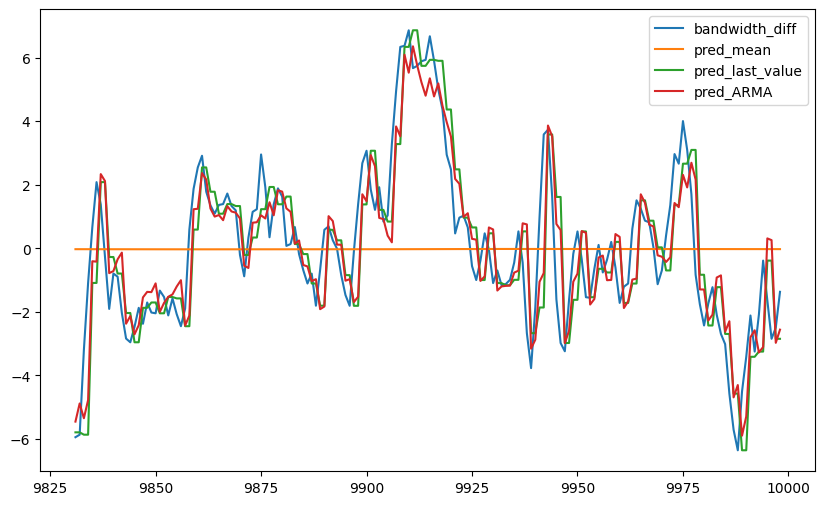

In [26]:
test.plot(figsize=(10,6))
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error
mse_mean = mean_squared_error(test['bandwidth_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['bandwidth_diff'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['bandwidth_diff'], test['pred_ARMA'])

print('MSE historical Mean', round(mse_mean, 3))
print('MSE last value', round(mse_last, 3))
print('MSE ARMA(2)', round(mse_ARMA, 3))

MSE historical Mean 6.307
MSE last value 2.23
MSE ARMA(2) 1.773


In [32]:
df['pred_bandwidth'] = pd.Series()
# 9832 = 10000 - 168
df['pred_bandwidth'][9832:] = df['hourly_bandwidth'].iloc[9832] + test['pred_ARMA'].cumsum()
df

,hourly_bandwidth,pred_bandwidth
0,1000.496714,NaN
1,1000.969408,NaN
2,1002.046019,NaN
3,1004.702118,NaN
4,1007.447816,NaN
...,...,...
9995,740.546059,721.366007
9996,738.906228,721.676869
9997,736.057995,721.933132
9998,733.559640,718.958045


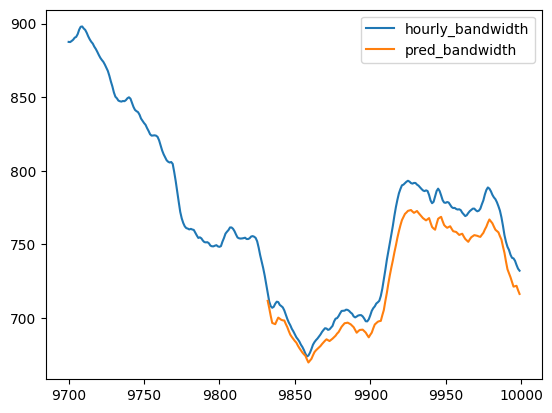

In [33]:
df.iloc[-300:].plot()
plt.show()

In [34]:
from sklearn.metrics import mean_absolute_error
mae_ARMA_undiff = mean_absolute_error(df['hourly_bandwidth'][9832:], df['pred_bandwidth'][9832:])
print(mae_ARMA_undiff)

df['hourly_bandwidth'].describe()

14.057975708101903


count    10000.000000
mean      1232.634448
std        615.204936
min        193.079868
25%        751.099777
50%       1064.494357
75%       1896.875640
max       2402.361236
Name: hourly_bandwidth, dtype: float64